In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
df = pd.read_csv("../data/processed/balanced_urls_with_features.csv")

X = df.drop(columns=["label_numeric"])
y = df["label_numeric"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    random_state=42
)

lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 91439, number of negative: 91439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 182878, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[18982  3878]
 [ 5719 17141]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     22860
           1       0.82      0.75      0.78     22860

    accuracy                           0.79     45720
   macro avg       0.79      0.79      0.79     45720
weighted avg       0.79      0.79      0.79     45720



In [6]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.05,
    verbose=0,
    random_state=42
)

cb_model.fit(X_train, y_train)

y_pred_cb = cb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb))


[[18949  3911]
 [ 5608 17252]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     22860
           1       0.82      0.75      0.78     22860

    accuracy                           0.79     45720
   macro avg       0.79      0.79      0.79     45720
weighted avg       0.79      0.79      0.79     45720



In [7]:
import numpy as np

p_lgb = lgb_model.predict_proba(X_test)[:, 1]
p_cb  = cb_model.predict_proba(X_test)[:, 1]

p_final = (p_lgb + p_cb) / 2
y_final = (p_final >= 0.5).astype(int)

print(confusion_matrix(y_test, y_final))
print(classification_report(y_test, y_final))


[[18987  3873]
 [ 5645 17215]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     22860
           1       0.82      0.75      0.78     22860

    accuracy                           0.79     45720
   macro avg       0.79      0.79      0.79     45720
weighted avg       0.79      0.79      0.79     45720



c:\Users\shahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\shahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


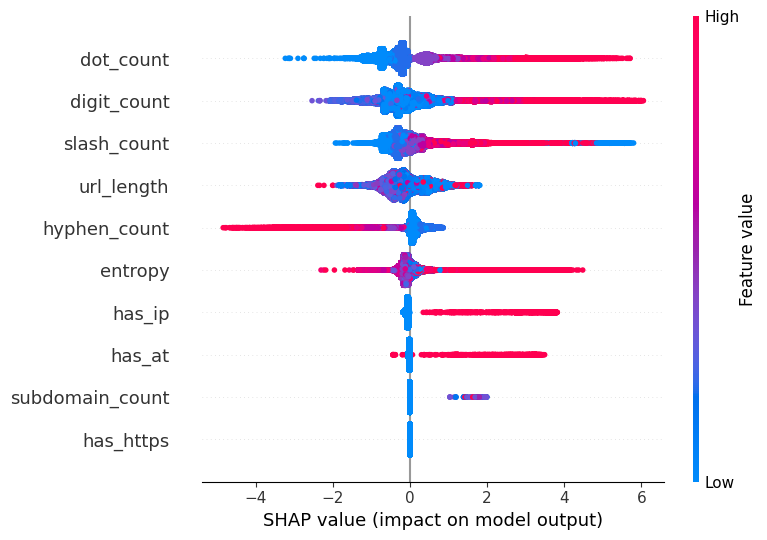

In [8]:
import shap

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [8]:
import joblib

joblib.dump(lgb_model, "../models/lightgbm.pkl")
joblib.dump(cb_model, "../models/catboost.pkl")


['../models/catboost.pkl']

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.83      0.80     22860
           1       0.82      0.75      0.78     22860

    accuracy                           0.79     45720
   macro avg       0.79      0.79      0.79     45720
weighted avg       0.79      0.79      0.79     45720



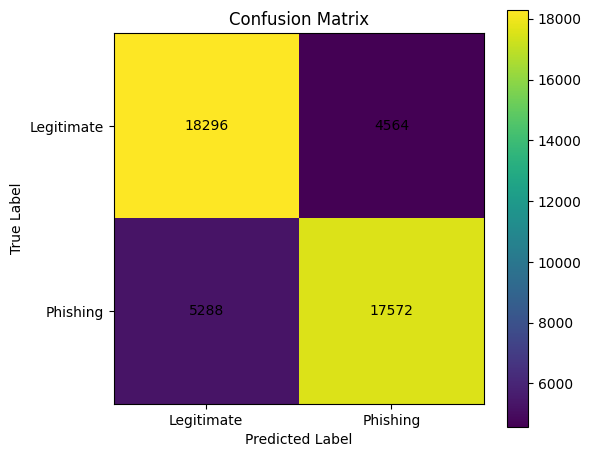

In [11]:
plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ["Legitimate", "Phishing"])
plt.yticks([0, 1], ["Legitimate", "Phishing"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()
